<h2>Part 3: Using classification to predict weather</h2>

<h3>Classification technique: Neural Network</h3>

In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from dm_tools import analyse_feature_importance
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
# Import data and process as for the decision tree
BOM_data = pd.read_csv('BOM_processed.csv')

In [3]:
# Drop redundant variables
BOM_data = BOM_data.drop(['Unnamed: 0','Date','Day','MinTemp','MaxTemp','Rainfall','Evaporation','Sunshine','WindGustDir','WindGustSpeed',
                          'WindDir9am','WindDir3pm','WindSpeed9am','WindSpeed3pm','Humidity3pm','Pressure3pm','Cloud3pm',
                          'Temp3pm','RainLastWeek','RainToday','ENSO','Year','Location'], axis=1)

In [4]:
BOM_data = BOM_data.dropna()

In [5]:
y = BOM_data['RainTomorrow'] # Target variable
X = BOM_data.drop(['RainTomorrow'], axis=1)

In [6]:
X_mat = X.to_numpy()

In [7]:
rs = 10

# Split into 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X_mat, y, test_size=0.2, stratify=y, random_state=rs)

In [8]:
# Standardise data ready for logistic regression
# initialise a standard scaler object
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_test = scaler.transform(X_test)

In [9]:
# Use MLPClassifier (multilayer perceptron classifier) from sklearn
# Use all default parameters
model_1 = MLPClassifier(max_iter=700, random_state=rs)
model_1.fit(X_train, y_train)

print("Train accuracy:", model_1.score(X_train, y_train))
print("Test accuracy:", model_1.score(X_test, y_test))

y_pred = model_1.predict(X_test)
print(classification_report(y_test, y_pred))

print(model_1)

Train accuracy: 0.8076217461320505
Test accuracy: 0.8063108973052305
              precision    recall  f1-score   support

         0.0       0.83      0.94      0.88     18954
         1.0       0.64      0.34      0.44      5575

    accuracy                           0.81     24529
   macro avg       0.73      0.64      0.66     24529
weighted avg       0.79      0.81      0.78     24529

MLPClassifier(max_iter=700, random_state=10)


In [10]:
# Show how many iterations and layers
print(model_1.n_iter_)
print(model_1.n_layers_)

69
3


In [11]:
# Default parameters look pretty good, no sign of overfitting
# See how many input features we have in the training set
print(X_train.shape)

(98114, 5)


In [12]:
# There are 5 variables and 98114 instances

In [13]:
# Now find optimal parameters with GridSearchCV
# First find optimal value for hidden_layer_sizes
# It has values of tuples, and within each tuple, element i-th represents the number of neurons contained in each hidden layer.
# default is 100
# Number of hidden layers should be < number of input nodes, but greater than number of output nodes
# General formula is (# input + # output)/2 +1
# Here we have 5 input variables, so the range should be 2-4
params = {'hidden_layer_sizes': [(x,) for x in range(2, 5, 1)]}

cv_1 = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs),return_train_score=True, cv=10, n_jobs=-1)
cv_1.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=MLPClassifier(random_state=10), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(2,), (3,), (4,)]},
             return_train_score=True)

In [14]:
result_set = cv_1.cv_results_
print(result_set)

{'mean_fit_time': array([15.77313044, 13.5450541 , 18.69586203]), 'std_fit_time': array([1.63579166, 4.22667201, 5.68798371]), 'mean_score_time': array([0.00679739, 0.00847218, 0.00603852]), 'std_score_time': array([0.00401954, 0.00956777, 0.00539868]), 'param_hidden_layer_sizes': masked_array(data=[(2,), (3,), (4,)],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'hidden_layer_sizes': (2,)}, {'hidden_layer_sizes': (3,)}, {'hidden_layer_sizes': (4,)}], 'split0_test_score': array([0.79973502, 0.79667754, 0.80055035]), 'split1_test_score': array([0.79739095, 0.79474113, 0.802181  ]), 'split2_test_score': array([0.79667754, 0.7970852 , 0.79871586]), 'split3_test_score': array([0.80768447, 0.8047289 , 0.80829596]), 'split4_test_score': array([0.79951075, 0.79747223, 0.80287432]), 'split5_test_score': array([0.80053002, 0.80053002, 0.80379166]), 'split6_test_score': array([0.79961268, 0.7993069 , 0.80114158]), 'split7_test_score': arra

In [15]:
print(cv_1.best_params_)

{'hidden_layer_sizes': (4,)}


Total number of models:  3


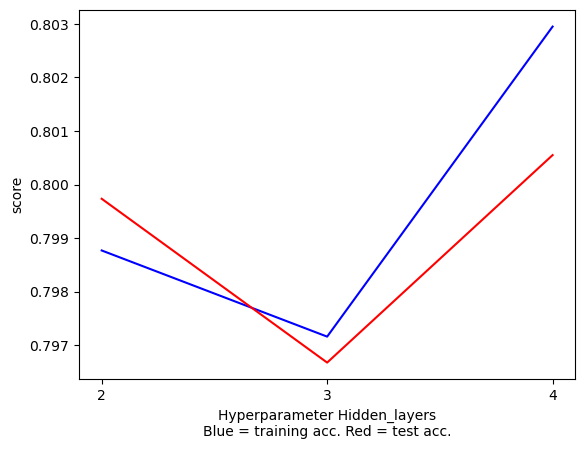

In [16]:
# Plot the test and train scores of split 1

train_result = result_set['split0_train_score']
test_result = result_set['split0_test_score']
print("Total number of models: ", len(test_result))
# plot hidden layers hyperparameter values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter Hidden_layers\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),range(2, 5, 1))
plt.ylabel('score')
plt.show()

Total number of models:  3


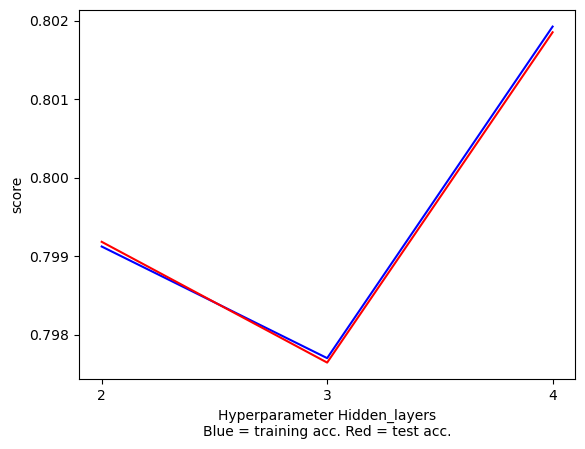

In [17]:
# Plot the mean train and test scores of all runs
train_result = result_set['mean_train_score']
test_result = result_set['mean_test_score']
print("Total number of models: ", len(test_result))
# plot hidden layers hyperparameter values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter Hidden_layers\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),range(2, 5, 1))
plt.ylabel('score')
plt.show()

In [18]:
# Next, we will tune the second hyperparameter, alpha, 
# Alpha is the learning rate for the gradient descent algorithm. 
# Larger alpha means the gradient descent will take "larger" steps and train faster, but it might miss the optimal solution. 
# Smaller alpha results in "smaller" steps, a slower training speed yet it might stuck at the local minimum.
# The default value for alpha is 0.0001, thus we will try alpha values around this number.

params = {'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv_2 = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv_2.fit(X_train, y_train)

print("Train accuracy:", cv_2.score(X_train, y_train))
print("Test accuracy:", cv_2.score(X_test, y_test))

y_pred = cv_2.predict(X_test)
print(classification_report(y_test, y_pred))

print(cv_2.best_params_)

Train accuracy: 0.8076625150335324
Test accuracy: 0.8068408822210444
              precision    recall  f1-score   support

         0.0       0.83      0.94      0.88     18954
         1.0       0.63      0.37      0.46      5575

    accuracy                           0.81     24529
   macro avg       0.73      0.65      0.67     24529
weighted avg       0.79      0.81      0.79     24529

{'alpha': 0.001}


In [19]:
result_set = cv_2.cv_results_
print(result_set)

{'mean_fit_time': array([45.04779012, 57.96336222, 70.67080514, 62.0725733 ]), 'std_fit_time': array([ 8.14563245, 13.42110703, 17.60339086, 14.22256384]), 'mean_score_time': array([0.04322841, 0.04046209, 0.0500896 , 0.0380872 ]), 'std_score_time': array([0.01340185, 0.01266216, 0.01781779, 0.01357585]), 'param_alpha': masked_array(data=[0.01, 0.001, 0.0001, 1e-05],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'alpha': 0.01}, {'alpha': 0.001}, {'alpha': 0.0001}, {'alpha': 1e-05}], 'split0_test_score': array([0.80320016, 0.80452507, 0.80320016, 0.802181  ]), 'split1_test_score': array([0.80574806, 0.80860171, 0.80758255, 0.80462699]), 'split2_test_score': array([0.8027925 , 0.80309825, 0.80207909, 0.80167142]), 'split3_test_score': array([0.81145536, 0.81227069, 0.81186302, 0.81400326]), 'split4_test_score': array([0.80695138, 0.8062379 , 0.80603404, 0.8062379 ]), 'split5_test_score': array([0.80786872, 0.8081745 , 0.8090

In [20]:
# Use MLPClassifier (multilayer perceptron classifier) from sklearn
# Use hidden layer size of 4 and alpha value of 0.001
model_2 = MLPClassifier(max_iter=700, random_state=rs, hidden_layer_sizes=(4,), alpha=0.001)
model_2.fit(X_train, y_train)

print("Train accuracy:", model_2.score(X_train, y_train))
print("Test accuracy:", model_2.score(X_test, y_test))

y_pred = model_2.predict(X_test)
print(classification_report(y_test, y_pred))

print(model_2)

Train accuracy: 0.8025664023482887
Test accuracy: 0.802071017978719
              precision    recall  f1-score   support

         0.0       0.83      0.94      0.88     18954
         1.0       0.63      0.32      0.43      5575

    accuracy                           0.80     24529
   macro avg       0.73      0.63      0.65     24529
weighted avg       0.78      0.80      0.78     24529

MLPClassifier(alpha=0.001, hidden_layer_sizes=(4,), max_iter=700,
              random_state=10)


In [21]:
# Show how many iterations and layers
print(model_2.n_iter_)
print(model_2.n_layers_)

70
3


In [22]:
# Use the decision tree model to perform feature selection for neural network modelling
# Use features from the best decision tree model previously created
import pickle
with open('DT.pickle', 'rb') as f:
    dt_best,roc_index_dt_cv, fpr_dt_cv, tpr_dt_cv = pickle.load(f)

print(dt_best)

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=15,
                       random_state=10)


In [23]:
analyse_feature_importance(dt_best, X.columns)

Humidity9am : 0.3474654927053538
Pressure9am : 0.3379490298144074
Cloud9am : 0.1389799493532587
Temp9am : 0.09370361636483789
Month : 0.08190191176214223


In [24]:
selectmodel = SelectFromModel(dt_best, prefit=True)
X_train_sel_model = selectmodel.transform(X_train)
X_test_sel_model = selectmodel.transform(X_test)

print(X_train_sel_model.shape)
X_train_sel_model

(98114, 2)


array([[-1.16333435,  0.02842152],
       [ 0.06625934,  0.73049788],
       [ 0.97508946,  0.14075374],
       ...,
       [ 0.28010172,  0.81474704],
       [-0.14758304,  0.09862916],
       [ 0.81470767,  1.03941147]])

In [25]:
# The decision tree model identfied 2 variables as important features. 
# Proceed to tune a MLPClassifier with this modified dataset.
# First tune with alpha variable

params = {'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv_sel_model = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv_sel_model.fit(X_train_sel_model, y_train)

print("Train accuracy:", cv_sel_model.score(X_train_sel_model, y_train))
print("Test accuracy:", cv_sel_model.score(X_test_sel_model, y_test))

y_pred = cv_sel_model.predict(X_test_sel_model)
print(classification_report(y_test, y_pred))

print(cv_sel_model.best_params_)

Train accuracy: 0.7951056933770919
Test accuracy: 0.7969342411023687
              precision    recall  f1-score   support

         0.0       0.81      0.96      0.88     18954
         1.0       0.65      0.23      0.34      5575

    accuracy                           0.80     24529
   macro avg       0.73      0.60      0.61     24529
weighted avg       0.77      0.80      0.76     24529

{'alpha': 0.001}


In [26]:
# The decision tree model identfied 2 variables as important features. 
# Proceed to tune a MLPClassifier with this modified dataset.
# Now tune with hidden layer sizes

params = {'hidden_layer_sizes': [(x,) for x in range(2, 5, 1)]}

cv_sel_model = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv_sel_model.fit(X_train_sel_model, y_train)

print("Train accuracy:", cv_sel_model.score(X_train_sel_model, y_train))
print("Test accuracy:", cv_sel_model.score(X_test_sel_model, y_test))

y_pred = cv_sel_model.predict(X_test_sel_model)
print(classification_report(y_test, y_pred))

print(cv_sel_model.best_params_)

Train accuracy: 0.7949120410950526
Test accuracy: 0.7963227200456603
              precision    recall  f1-score   support

         0.0       0.81      0.96      0.88     18954
         1.0       0.64      0.24      0.35      5575

    accuracy                           0.80     24529
   macro avg       0.72      0.60      0.62     24529
weighted avg       0.77      0.80      0.76     24529

{'hidden_layer_sizes': (3,)}


In [27]:
# The optimal parameters were  the same with the reduced feature set
# Use MLPClassifier (multilayer perceptron classifier) from sklearn
# Use hidden layer size of 4 and alpha value of 0.001
# Use the reduced data set with only 2 variables
model_3 = MLPClassifier(random_state=rs, hidden_layer_sizes=(3,), alpha=0.001)
model_3.fit(X_train_sel_model, y_train)

print("Train accuracy:", model_3.score(X_train_sel_model, y_train))
print("Test accuracy:", model_3.score(X_test_sel_model, y_test))

y_pred = model_3.predict(X_test_sel_model)
print(classification_report(y_test, y_pred))

print(model_3)

Train accuracy: 0.7948814644189413
Test accuracy: 0.7964042561865546
              precision    recall  f1-score   support

         0.0       0.81      0.96      0.88     18954
         1.0       0.64      0.24      0.35      5575

    accuracy                           0.80     24529
   macro avg       0.72      0.60      0.62     24529
weighted avg       0.77      0.80      0.76     24529

MLPClassifier(alpha=0.001, hidden_layer_sizes=(3,), random_state=10)


In [28]:
# Accuracy went slightly down. So the best model was the default model.

In [29]:
# Show how many iterations and layers
print(model_3.n_iter_)
print(model_3.n_layers_)
print(model_3.out_activation_)

30
3
logistic


<h2>Comparison of all predictive models</h2>

In [35]:
# Compare the 3 models using area under ROC curve.
y_pred_proba_default = model_1.predict_proba(X_test)
roc_index_default = roc_auc_score(y_test, y_pred_proba_default[:, 1])
print("ROC index on test for `default`:", roc_index_default)

ROC index on test for `default`: 0.8060772576135473


In [36]:
# Prepare for plotting ROC curves
fpr_neural, tpr_neural, thresholds_neural = roc_curve(y_test, y_pred_proba_default[:,1])

In [37]:
# Will compare the best decision tree, logistic regression model and nueral network model
# Import required variables for plotting ROC curve of each

%store -r fpr_dt
%store -r tpr_dt
%store -r thresholds_dt
%store -r roc_index_dt
%store -r fpr_reg
%store -r tpr_reg
%store -r thresholds_reg
%store -r roc_index_reg

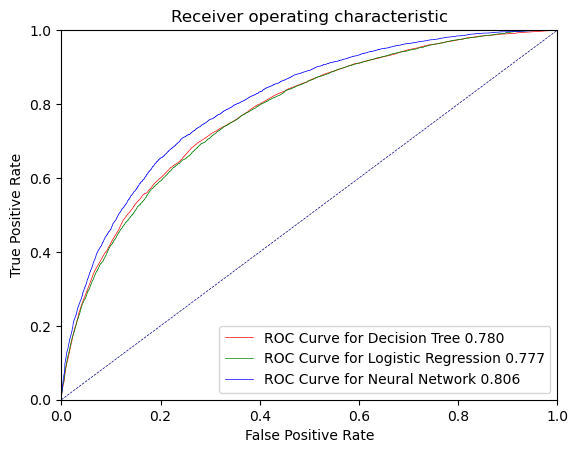

In [34]:
# Plot the ROC curves
plt.plot(fpr_dt, tpr_dt, label='ROC Curve for Decision Tree {:.3f}'.format(roc_index_dt), color='red', lw=0.5)
plt.plot(fpr_reg, tpr_reg, label='ROC Curve for Logistic Regression {:.3f}'.format(roc_index_reg), color='green', lw=0.5)
plt.plot(fpr_neural, tpr_neural, label='ROC Curve for Neural Network {:.3f}'.format(roc_index_neural), color='blue', lw=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()